In [7]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import pandas as pd
import skfuzzy as fuzz
from functools import partial

In [8]:
def distance_weighted(x,y,mu):
    return np.sum(np.array(mu)*(x-y)**2)

### Preprocessing

In [19]:
import pandas as pd
train_data = pd.read_csv('data/BATADAL/BATADAL_dataset04.csv')


In [57]:
train_data[" ATT_FLAG"].value_counts()
df_np_label = train_data.drop(["DATETIME", " ATT_FLAG"], axis=1).values


In [58]:
def generate_subsequences(data, window_size, step_size):
    num_points, num_variables = data.shape
    number_subs = int((num_points - window_size)/step_size) + 1  # Number of subsequences

    subsequences = np.zeros((number_subs, window_size, num_variables))

    for i in range(number_subs):
        subsequences[i, :, :] = data[i*step_size:i*step_size+window_size, :]
    return subsequences

def reconstructed_loss(reconstructed_points, initial_points):
    return np.linalg.norm(reconstructed_points - initial_points, ord=2, axis=1)


In [59]:
window_size = 10
stride = 5
sequences = generate_subsequences(df_np_label, window_size, stride)
label_sequences = generate_subsequences(train_data[" ATT_FLAG"].values.reshape(-1,1), window_size, stride)

In [35]:
data_for_clustering = sequences.reshape(sequences.shape[0], -1)
mu = [1/data_for_clustering.shape[1] for i in range(data_for_clustering.shape[1])]

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(data_for_clustering.T, 3, 2,metric = partial(distance_weighted, mu = mu), error=0.005, maxiter=1000, init=None)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]



In [36]:
loss = reconstructed_loss(reconstructed_points, data_for_clustering)


In [37]:
np.sum(loss)

145685.73285278652

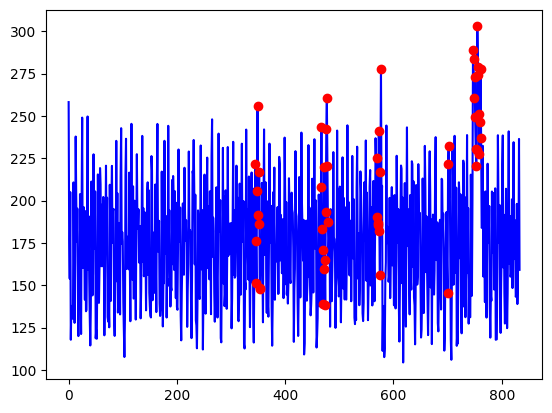

In [38]:
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

#plot loss
plt.plot(range(len(loss)), loss, color='blue', label='Label 0')

# Plot red points for anomalies
plt.plot(label_1_indices, loss[label_1_indices], 'ro', label='Label 1')

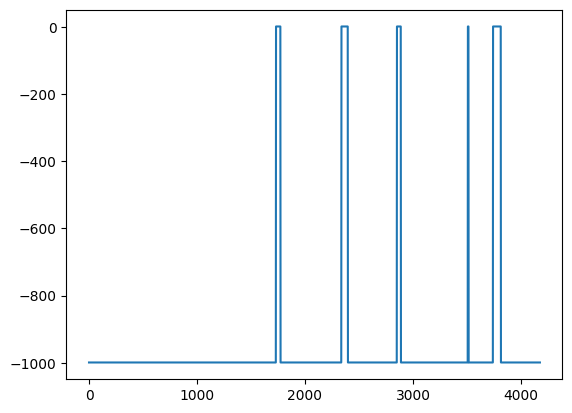

In [39]:
plt.plot(train_data[" ATT_FLAG"].values)

### Optimization PSO

In [45]:
def cost_function(data,mu):
    mu = mu/np.sum(mu)
    mu = np.repeat(mu, window_size)
    print(np.std(mu))
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(data.T, 3, 2,metric = partial(distance_weighted, mu = mu), error=0.005, maxiter=1000, init=None)
    # Reconstruction of initial points
    reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]
    return np.sum(reconstructed_loss(reconstructed_points, data))

# Define the PSO algorithm
def pso(cost_func, data_for_clustering, dim=2, num_particles=3, max_iter=10, w=0.5, c1=1, c2=2):
    cost_function_with_data  = partial(cost_func, data = data_for_clustering)
    # Initialize particles and velocities
    particles = np.random.uniform(50, 100, (num_particles, dim))
    velocities = np.zeros((num_particles, dim))
    #particles = np.array([p / np.sum(p) for p in particles])
    # Initialize the best positions and fitness values
    best_positions = np.copy(particles)
    best_fitness = np.array([cost_function_with_data(mu = p) for p in particles])
    swarm_best_position = best_positions[np.argmin(best_fitness)]
    swarm_best_fitness = np.min(best_fitness)

    # Iterate through the specified number of iterations, updating the velocity and position of each particle at each iteration
    for i in range(max_iter):
        # Update velocities
        r1 = np.random.uniform(0, 1, (num_particles, dim))
        r2 = np.random.uniform(0, 1, (num_particles, dim))
        velocities = w * velocities + c1 * r1 * (best_positions - particles) + c2 * r2 * (swarm_best_position - particles)

        # Update positions
        particles += velocities
        #particles = np.array([p / np.sum(p) for p in particles])
        # Evaluate fitness of each particle
        test_neg = [np.min(p) for p in particles]
        if np.min(test_neg) < 0:
            print("NEGATIVE WEIGHTS GENERATED")
        particles[particles < 0] = 0
        fitness_values = np.array([cost_function_with_data(mu =p) for p in particles])

        # Update best positions and fitness values
        improved_indices = np.where(fitness_values < best_fitness)
        best_positions[improved_indices] = particles[improved_indices]
        best_fitness[improved_indices] = fitness_values[improved_indices]
        if np.min(fitness_values) < swarm_best_fitness:
            swarm_best_position = particles[np.argmin(fitness_values)]
            swarm_best_fitness = np.min(fitness_values)

    # Return the best solution found by the PSO algorithm
    return swarm_best_position, swarm_best_fitness
# Define the dimensions of the problem
dim = df_np_label.shape[1]
# Run the PSO algorithm on the Rastrigin function
solution, fitness = pso(cost_function, data_for_clustering, dim=dim)

# Print the solution and fitness value
print('Solution:', solution)
print('Fitness:', fitness)

0.004740534228116978
0.004952950845133837
0.004559942476134759
0.006264348627055608
0.005717429633968228
0.004559942476134759
NEGATIVE WEIGHTS GENERATED
0.009548840532785161
0.006927078250598988
0.007008910622412318
0.008395261368175363
0.01014281957635605
0.007797147157045947
NEGATIVE WEIGHTS GENERATED
0.011512217688554517
0.011890126402276546
0.012036633545833291
NEGATIVE WEIGHTS GENERATED
0.01537796008946657
0.013942254324222181
0.014176626465312757
NEGATIVE WEIGHTS GENERATED
0.014316516867250158
0.014788898320215344
0.015064253345811268
NEGATIVE WEIGHTS GENERATED
0.014569168283928102
0.01573626184242564
0.015378698875387514
NEGATIVE WEIGHTS GENERATED
0.014648289207569642
0.01595026011594995
0.015004430458910884
NEGATIVE WEIGHTS GENERATED
0.01577349351342602
0.01621660607510784
0.0153423822966746
NEGATIVE WEIGHTS GENERATED
0.016439461367419212
0.01621968536787699
0.01711009613518482
Solution: [  0.          67.39413604   0.         316.18000383  47.97470244
  50.96987699  85.5237135

In [46]:
fitness

144197.67639555666

In [47]:
mu = solution
mu = mu/np.sum(mu)
mu = np.repeat(mu, window_size)
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(data_for_clustering.T, 3, 2,metric = partial(distance_weighted, mu = mu), error=0.005, maxiter=1000, init=None)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

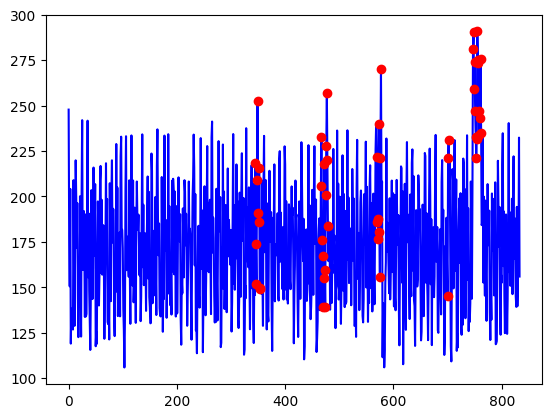

In [60]:
loss = reconstructed_loss(reconstructed_points, data_for_clustering)
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

#plot loss
plt.plot(range(len(loss)), loss, color='blue', label='Label 0')

# Plot red points for anomalies
plt.plot(label_1_indices, loss[label_1_indices], 'ro', label='Label 1')

In [70]:
! pip install wget


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=dcb96f6831029daaaadbcc665c2d73f57517a8110a850c31158e216aa998df3a
  Stored in directory: c:\users\paulc\appdata\local\pip\cache\wheels\8b\f1\7f\5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [72]:
! wget "https://s3-us-west-2.amazonaws.com/telemanom/data.zip" && unzip data.zip && rm data.zip


'wget' is not recognized as an internal or external command,
operable program or batch file.
